In [1]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string


c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Methods

In [2]:
def load_stop_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stop_words = set(file.read().splitlines())
    return stop_words

## Dataset

In [3]:
dataset = pd.read_json("dataset\Turkish_data_depository_630koseyazisi.jsonl",lines=True)
print(dataset.head(10))
print(dataset.info())

  writer  file_id                                             column
0    ttu       27  O zaman 28 Şubat neden yapıldı?  \r\n     \r\n...
1    ttu       28  O zaman 28 Şubat neden yapıldı?  \r\n     \r\n...
2    ttu        3  Cumhuriyetin en kritik yerel seçimi \r\nMURAT ...
3    ttu        4  Çekilin artık kamera karşısından \r\nHER kar y...
4    ttu       23  Lorant'ın heyecan veren hedefi  \r\n     \r\n\...
5    ttu       14  Gerçekten de gülüp geçilecek bir öneri \r\nGAZ...
6    ttu       13  Mercedes çeşitlemeleri \r\nTÜRK insanı, Merced...
7    ttu       31  Yazarın çilesi  \r\n     \r\n\r\n  \r\nZAMAN z...
8    ttu       19  Tüm yazı konularını silip süpüren fotoğraf \r\...
9    ttu       11  Şarkta böyledir bu işler...  \r\n     \r\nttu...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   writer   630 non-null    object
 1   file_id  630 non-null

In [4]:
x = dataset.iloc[:, 2].values.astype("str") # author text
y = dataset.iloc[:, 0].values.astype("str") # author name

print(f"type x : {type(x)} , type y : {type(y)}")

type x : <class 'numpy.ndarray'> , type y : <class 'numpy.ndarray'>


## Preprocesing

In [5]:
# turkish stop words
stop_words =  load_stop_words("stopwordsTR\stopwords.txt")

# Her bir metni temizleme işlemi
for i in range(len(x)):
    # Convert to lowercase - Küçük harfe çevirme
    x[i] = x[i].lower()
    
    # Remove escape characters - Kaçış karakterlerini kaldırma
    x[i] = re.sub(r'[\r\n]', ' ', x[i]) 
    
    # Remove unnecessary characters - Gereksiz karakterleri kaldırma
    x[i] = re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]', '', x[i])
    
    # Remove stop words - Stop kelimeleri kaldırma
    x[i] = ' '.join([word for word in x[i].split() if word not in stop_words])
    
    # Remove punctuation marks - Noktalama işaretlerini kaldırma
    x[i] = x[i].translate(str.maketrans('', '', string.punctuation))
    
    # Remove repeating spaces - Tekrar eden boşlukları kaldırma
    x[i] = re.sub(r'\s+', ' ', x[i])

# BERT model

In [6]:
# Veri setini eğitim ve test olarak ayırma
train_texts, test_texts, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=42)

train_texts = train_texts.tolist()
test_texts = test_texts.tolist()

# BERT tokenizer'ını yükleme
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')

# Eğitim verilerini tokenleştirme
tokenized_train_texts = tokenizer(train_texts, padding=True, truncation=True, max_length=100, return_tensors="pt")

# Test verilerini tokenleştirme
tokenized_test_texts = tokenizer(test_texts, padding=True, truncation=True, max_length=100, return_tensors="pt")

c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:

# etiketleri sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.fit_transform(test_labels)


# Etiketleri tensor'a dönüştürme
train_labels_tensor = torch.tensor(train_labels_encoded)
test_labels_tensor = torch.tensor(test_labels_encoded)

# Veri setlerini oluşturma
train_dataset = TensorDataset(tokenized_train_texts['input_ids'], tokenized_train_texts['attention_mask'], train_labels_tensor)
test_dataset = TensorDataset(tokenized_test_texts['input_ids'], tokenized_test_texts['attention_mask'], test_labels_tensor)

# Veri yükleyicilerini oluşturma
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
# BERT modelini yükleme
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased', num_labels=len(set(y)))

# Cihaza alma
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Modeli eğitme
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, inputs['labels'])
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", total_loss)

c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 Loss: 45.65355825424194
Epoch: 1 Loss: 36.86285364627838
Epoch: 2 Loss: 29.458127856254578
Epoch: 3 Loss: 21.777350544929504
Epoch: 4 Loss: 14.221141159534454


In [9]:
# Modelin performansını değerlendirme
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        labels = batch[2]
        outputs = model(**inputs)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Doğruluk hesaplama
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predictions)
print("Doğruluk (Accuracy):", accuracy)

# classificaiton report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

Doğruluk (Accuracy): 0.47619047619047616
              precision    recall  f1-score   support

           0       0.10      0.25      0.14         4
           1       0.50      0.38      0.43         8
           2       0.43      0.75      0.55         4
           3       1.00      1.00      1.00         5
           4       1.00      0.36      0.53        11
           5       0.56      0.62      0.59         8
           6       0.00      0.00      0.00         6
           7       0.88      0.78      0.82         9
           8       0.33      1.00      0.50         5
           9       0.50      0.67      0.57         6
          10       0.67      0.67      0.67         9
          11       0.38      0.30      0.33        10
          12       0.00      0.00      0.00         5
          13       1.00      0.22      0.36         9
          14       0.09      0.17      0.12         6
          15       0.40      0.67      0.50         6
          16       1.00      0.62      0

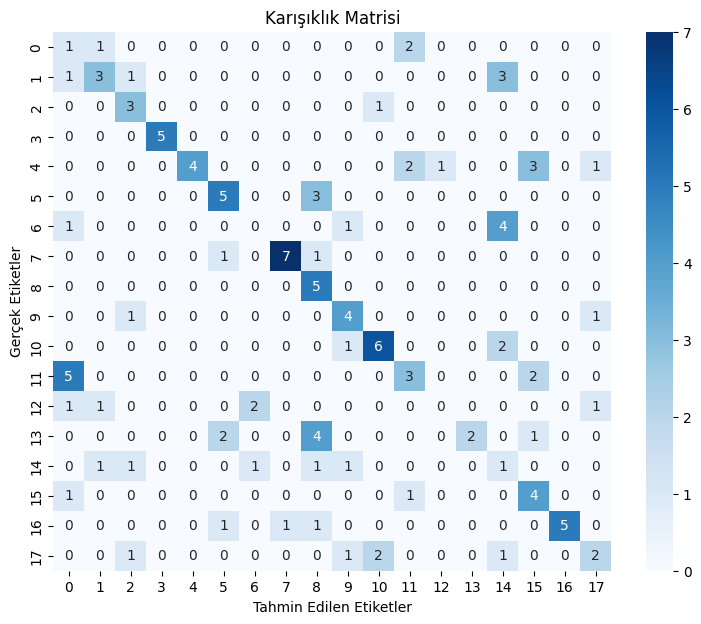

In [10]:
# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(true_labels, predictions)

# Görselleştirme
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title('Karışıklık Matrisi')
plt.show()

In [11]:
# BERT modelini yükleme
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased', num_labels=len(set(y)))

# Cihaza alma
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Modeli eğitme
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, inputs['labels'])
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", total_loss)

c:\Users\Umitk\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 Loss: 46.428335428237915
Epoch: 1 Loss: 41.067177534103394
Epoch: 2 Loss: 32.0384806394577
Epoch: 3 Loss: 24.026224970817566
Epoch: 4 Loss: 16.816519498825073
Epoch: 5 Loss: 10.265401482582092
Epoch: 6 Loss: 5.85315328836441
Epoch: 7 Loss: 3.00174543261528
Epoch: 8 Loss: 1.8716538920998573
Epoch: 9 Loss: 1.2103602141141891


In [13]:
# Modelin performansını değerlendirme
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        labels = batch[2]
        outputs = model(**inputs)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Doğruluk hesaplama
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predictions)
print("Doğruluk (Accuracy):", accuracy)

# classificaiton report
print(classification_report(true_labels, predictions))

Doğruluk (Accuracy): 0.48412698412698413
              precision    recall  f1-score   support

           0       0.29      0.50      0.36         4
           1       1.00      0.12      0.22         8
           2       0.50      0.50      0.50         4
           3       1.00      1.00      1.00         5
           4       1.00      0.09      0.17        11
           5       0.56      0.62      0.59         8
           6       0.20      0.50      0.29         6
           7       1.00      0.67      0.80         9
           8       0.42      1.00      0.59         5
           9       0.22      0.33      0.27         6
          10       0.70      0.78      0.74         9
          11       0.67      0.60      0.63        10
          12       0.50      0.20      0.29         5
          13       0.50      0.33      0.40         9
          14       0.27      0.50      0.35         6
          15       0.43      0.50      0.46         6
          16       0.83      0.62      0

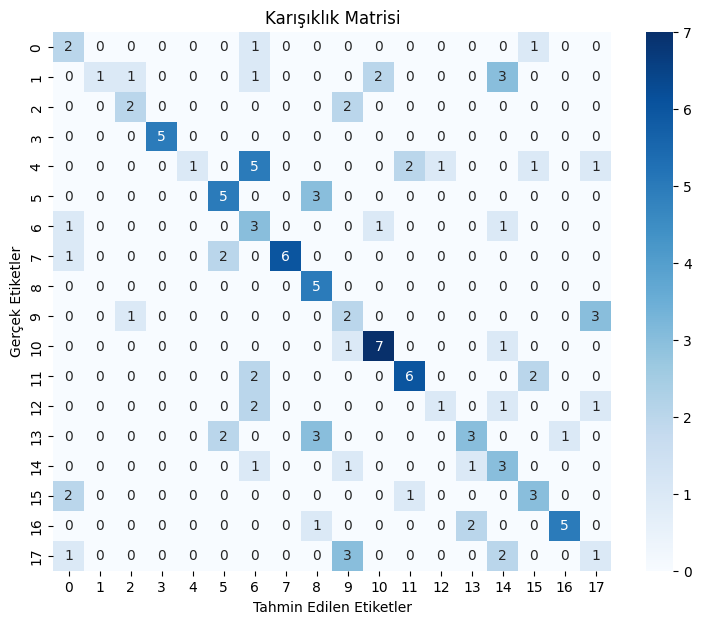

In [14]:
# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(true_labels, predictions)

# Görselleştirme
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title('Karışıklık Matrisi')
plt.show()